In [1]:
import cv2
import torch
import torchvision
import numpy as np
import copy
import random
from google.colab import drive
from google.colab.patches import cv2_imshow
from torchvision.io.image import read_image
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

# print(torchvision.__version__)
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# test_img1 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q1.jpg", cv2.IMREAD_COLOR)
# test_img1 = cv2.resize(test_img1, (800, 600))
# test_img1 = [test_img1, 0.1, 0.5]
# test_img2 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q2.jpg", cv2.IMREAD_COLOR)
# test_img2 = cv2.resize(test_img2, (800, 600))
# test_img2 = [test_img2, 0.2, 0.1]
# test_img3 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q5.jpg", cv2.IMREAD_COLOR)
# test_img3 = cv2.resize(test_img3, (800, 600))
# test_img3 = [test_img3, 0.3, 0.6]
# test_img4 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q6.jpg", cv2.IMREAD_COLOR)
# test_img4 = cv2.resize(test_img4, (800, 600))
# test_img4 = [test_img4, 0.4, 0.3]
# heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart_heart.jpg", cv2.IMREAD_COLOR)
# heart_img = cv2.resize(heart_img, (800, 600))

In [2]:
q = np.load("/content/gdrive/MyDrive/Colab Notebooks/image/bts_thumb_imgs.npy", allow_pickle=True)

In [3]:
len(q)

54

In [6]:
for i in range(len(q)):
  cv2_imshow(q[i][0])
  print()

Output hidden; open in https://colab.research.google.com to view.

In [3]:
# input_data = np.array([test_img1,test_img2, test_img3, test_img4])
# input_data = [test_img1,test_img2, test_img3, test_img4]
input_data = q[:20].tolist()
input_data.sort(reverse=True, key=lambda x:x[2])   # frame_score로 정렬

In [8]:
for i in input_data:
    cv2_imshow(i[0])

Output hidden; open in https://colab.research.google.com to view.

In [4]:
original_height, original_width = input_data[0][0].shape[:2]
original_img_size = original_height * original_width

In [5]:
for i in input_data:
    if i[0].shape[1] > 1500:
        i[0] = cv2.resize(i[0], (None, None), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    elif i[0].shape[1] > 1000:
        i[0] = cv2.resize(i[0], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)

background_img = input_data.pop()[0]
tmp_height, tmp_width = input_data[0][0].shape[:2]
tmp_img_size = tmp_height * tmp_width

In [11]:
# for i in range(len(input_data)):
#     cv2_imshow(input_data[i][0])

In [6]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()

model = maskrcnn_resnet50_fpn(weights=weights)
model = model.eval()

In [7]:
input_img_list = []
tt = torchvision.transforms.ToTensor()

for i in range(len(input_data)):
    input_img_list.append(tt(input_data[i][0]))

In [8]:
def make_mask(outputs):
    img_num = len(outputs)
    tmp_dic = {}
    prior_label = [1, 18, 17, 52, 53, 54, 55, 59, 60, 61, 85, 88, 37, 6, 46, 5, 7, 64, 73]
    del_list = []
    real_dic = {}
    score_dic = {}
    proportion = 0.1
    proba_threshold = 0.5
    mask_img = []
    

    for i in prior_label:
      real_dic[i] = -1

    
    # boxes 버리고 각 이미지에서 레이블 중복되는 거 버림
    for i in range(img_num):
        # del outputs[i]["boxes"]   ##
        outputs[i]["labels"] = outputs[i]["labels"].detach().numpy()
        outputs[i]["scores"] = outputs[i]["scores"].detach().numpy()
        outputs[i]["masks"] = torch.squeeze(outputs[i]["masks"], 1)
        outputs[i]["masks"] = outputs[i]["masks"].detach().numpy()
        del_idx = []

        for j in range(1, len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in outputs[i]["labels"][:j]:
                del_idx.append(j)

        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)

        outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], -1)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)


    # tmp_dic에 레이블당 score가 가장 높은 애들을 저장
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] not in tmp_dic:
                tmp_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]
            else:
                if outputs[i]["scores"][j] > tmp_dic[outputs[i]["labels"][j]]:
                    tmp_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]


    # 레이블당 score가 가장 높은 애들을 제외하고 나머지는 삭제
    for i in range(img_num):
        del_idx = []
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in tmp_dic.keys():
                if tmp_dic[outputs[i]["labels"][j]] != outputs[i]["scores"][j]:
                    del_idx.append(j)
        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)
        outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], tmp_height, tmp_width)

    
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in real_dic.keys() and outputs[i]["scores"][j] > 0.7:
                real_dic[outputs[i]["labels"][j]] = i
            else:
                pass
                #####################
                # outputs[i]["masks"][j] = np.where(outputs[i]["masks"][j] < proba_threshold, 0, outputs[i]["masks"][j])
                # nonzero_cnt = np.count_nonzero(outputs[i]["masks"][j])
                
                # if nonzero_cnt / tmp_img_size >= proportion:
                #     score_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]


    for i in real_dic.keys():
        if real_dic[i] == -1:
            del_list.append(i)

    for i in del_list:
        del real_dic[i]

    del_list = []

    score_dic = dict(sorted(score_dic.items(), key=lambda x: x[1], reverse=True))

    for i in score_dic.keys():
        if score_dic[i] < 0.7:
            del_list.append(i)

    for i in del_list:
        del score_dic[i]
    
    for i in range(img_num):
        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] in score_dic.keys():
                score_dic[outputs[i]["labels"][j]] = i

    real_dic.update(score_dic)

    while len(real_dic.keys()) > 8:
        del real_dic[list(real_dic.keys())[-1]]


    # outputs에서 사용할 label, score, mask 빼고 다 삭제
    for i in range(img_num):
        del outputs[i]["scores"]
        del_idx = []

        for j in range(len(outputs[i]["labels"])):
            if outputs[i]["labels"][j] not in real_dic.keys():
                del_idx.append(j)

        outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
        outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)

    tmp_l = list(real_dic.values())

    while len(mask_img) != len(real_dic.keys()):
        for i in range(img_num):
            if i == tmp_l[0]:
                outputs[i]["masks"][0] = np.where(outputs[i]["masks"][0] < 0.25, 0, 255)
                dst = input_data[i][0].copy()
                dst = cv2.bitwise_and(dst, dst, mask=outputs[i]["masks"][0].astype("uint8"))
                mask_img.append(dst)
                tmp_l.pop(0)
                break

        outputs[i]["masks"] = np.delete(outputs[i]["masks"], 0, axis=0)
    
    return real_dic, mask_img   # real_dic 삭제하기

In [9]:
def make_thumbnail_fg(mask_img):
    heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart_heart_heart.jpg", cv2.IMREAD_COLOR)
    # heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/hh.jpg", cv2.IMREAD_COLOR)
    heart_img = cv2.resize(heart_img, (800, 600))
    img_list = []
    mask_img_copy = mask_img

    for i in range(len(mask_img)):
        tmp = cv2.cvtColor(mask_img[i], cv2.COLOR_BGR2GRAY)
        _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)

        for j in range(1, cnt):
            (x, y, w, h, area) = stats[j]

            if area / tmp_img_size < 1 / 20:
                tmp[y:y+h, x:x+w] = 0
            
        a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(a) != 0:
            cv2.drawContours(mask_img_copy[i], a, -1, (255, 255, 255), 11)
            tmp = cv2.bitwise_and(mask_img_copy[i], mask_img_copy[i], mask=tmp)
            img_list.append(tmp)
        

    for i in range(len(img_list)):
        tmp = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY)
        _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)
        (x, y, w, h, area) = stats[1]

        m = np.float32([[1, 0, -x], [0, 1, -y]])

        img_list[i] = cv2.warpAffine(img_list[i], m, (0, 0))

        if i == 0:
            if area / tmp_img_size > 1/ 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.65, fy=0.65, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.75, fy=0.75, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.85, fy=0.85, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.95, fy=0.95, interpolation=cv2.INTER_AREA)
            else:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
        elif i == 1:
            if area / tmp_img_size > 1/ 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.8, fy=0.8, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.9, fy=0.9, interpolation=cv2.INTER_AREA)
            else:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)

        elif i == 2 or i == 3:
            if area / tmp_img_size > 1/ 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.35, fy=0.35, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.45, fy=0.45, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1/ 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.85, fy=0.85, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size < 1 / 25:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
        else:
            if area / tmp_img_size >= 1 / 2:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 3:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 6:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 10:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 15:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.6, fy=0.6, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size > 1 / 20:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)
            elif area / tmp_img_size < 1 / 30:
                img_list[i] = cv2.resize(img_list[i], (None, None), fx=1.1, fy=1.1, interpolation=cv2.INTER_LINEAR)
    

    ####################
    # while len(img_list) < 6:
    #     heart_img = cv2.cvtColor(heart_img, cv2.COLOR_BGR2HSV)
    #     heart_img_copy = heart_img.copy()

    #     tmp = cv2.cvtColor(heart_img, cv2.COLOR_BGR2GRAY)
    #     _, tmp = cv2.threshold(tmp, 0.9, 255, cv2.THRESH_BINARY)

    #     # a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #     # cv2.drawContours(heart_img_copy, a, -1, (255, 255, 255), 11)

    #     # heart_img = cv2.bitwise_and(heart_img_copy, heart_img_copy, mask=tmp)

    #     cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)

    #     area_sum = 0

    #     for i in range(1, cnt):
    #         (x, y, w, h, area) = stats[i]
    #         area_sum += area

    #     if area_sum / tmp_img_size >= 1 / 2:
    #             heart_img = cv2.resize(heart_img, (None, None), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 3:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.35, fy=0.35, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 6:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.45, fy=0.45, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 10:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.55, fy=0.55, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 15:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.65, fy=0.65, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size > 1 / 20:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=0.75, fy=0.75, interpolation=cv2.INTER_AREA)
    #     elif area_sum / tmp_img_size < 1 / 30:
    #         heart_img = cv2.resize(heart_img, (None, None), fx=1.1, fy=1.1, interpolation=cv2.INTER_LINEAR)
            
    #     # a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #     # cv2.drawContours(heart_img_copy, a, -1, (255, 255, 255), 11)

    #     # heart_img = cv2.bitwise_and(heart_img_copy, heart_img_copy, mask=tmp)

    #     img_list.append(heart_img)


    for i in range(len(img_list)):
        bg = np.zeros((tmp_height, tmp_width, 3), dtype=np.uint8)

        if img_list[i].shape[0] > bg.shape[0]:
            bg[:bg.shape[0], :bg.shape[1]] = img_list[i][:bg.shape[0], :bg.shape[1]]
        else:
            bg[:img_list[i].shape[0], :img_list[i].shape[1]] = img_list[i]

        img_list[i] = bg


    pos_dic = {}

    for i in range(len(img_list)):
        tmp = cv2.cvtColor(img_list[i], cv2.COLOR_BGR2GRAY)
        _, tmp = cv2.threshold(tmp, 1, 255, cv2.THRESH_BINARY)

        cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(tmp)
        centroids = centroids.astype(np.int64)
        (x, y, w, h, area) = stats[1]
        pos_dic[i] = [x, y, w, h, area, (centroids[1][0], centroids[1][1])]

        if i == 0:
            shift_x = 10
            shift_y = tmp_height - h

        elif i == 1:
            shift_x = tmp_width - w - 10
            shift_y = tmp_height - h
        
        elif i == 2:
            shift_x = pos_dic[0][2] + 10
            shift_y = tmp_height - pos_dic[0][3] - int(h / 3)

        elif i == 3:
            shift_x = tmp_width - w - 10
            shift_y = tmp_height - pos_dic[1][3] - h - 10

        else:
            if i == 4:
                shift_x = 20
                shift_y = 20
            else:
                # shift_x = pos_dic[0][2] + pos_dic[2][2] + 20
                # shift_x = (pos_dic[2][2] + pos_dic[4][2]) * int(1 + i / 10)
                # shift_y = pos_dic[i - 1][3] - int(pos_dic[i][3] / 2)
                shift_x = int(tmp_width / (15 - i) * i)
                shift_y += int(pos_dic[i][3] / 3)


        m = np.float32([[1, 0, int(shift_x)], [0, 1, int(shift_y)]])
        img_list[i] = cv2.warpAffine(img_list[i], m, (0, 0))


    dst1 = np.zeros((tmp_height, tmp_width, 3), np.uint8)

    for i in img_list[::-1]:
        # dst2 = cv2.add(dst2, i)
        # dst2 = cv2.bitwise_or(dst2, i)

        gray_tmp = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_tmp, 0.1, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        masked_fg = cv2.bitwise_and(i, i, mask=mask)
        masked_bg = cv2.bitwise_and(dst1, dst1, mask=mask_inv)

        dst1 = masked_fg + masked_bg

    return dst1

In [10]:
def make_thumbnail_bg(dst1, bg_image=True, bg_c="sky", text_f="TRIPLEX", text_c="black",text="VLOG", font_scale=2, font_thickness=2):
    bg_color = {"sky": cv2.merge([np.full((tmp_height, tmp_width), 255, np.uint8), np.full((tmp_height, tmp_width), 204, np.uint8), np.full((tmp_height, tmp_width), 153, np.uint8)]),
            "pink": cv2.merge([np.full((tmp_height, tmp_width), 255, np.uint8), np.full((tmp_height, tmp_width), 51, np.uint8), np.full((tmp_height, tmp_width), 255, np.uint8)]),
            "red": cv2.merge([np.full((tmp_height, tmp_width), 0, np.uint8), np.full((tmp_height, tmp_width), 0, np.uint8), np.full((tmp_height, tmp_width), 255, np.uint8)]),
            }
    text_color = {"black": (0, 0, 0), "red": (0, 0, 255), "blue": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}
    text_font = {"SIMPLEX": cv2.FONT_HERSHEY_SIMPLEX, "TRIPLEX": cv2.FONT_HERSHEY_TRIPLEX, "ITALIC": cv2.FONT_ITALIC}

    if bg_image:
        dst2 = background_img
    else:
        dst2 = bg_color[bg_c]

    text_size = cv2.getTextSize(text, text_font[text_f], font_scale, font_thickness)[0]
    text_x = int((dst2.shape[1] - text_size[0]) / 2)
    text_y = int((dst2.shape[0] - text_size[1]) / 4 * 3)
    dst1_gray = cv2.cvtColor(dst1, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(dst1_gray, 0.1, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    masked_fg = cv2.bitwise_and(dst1, dst1, mask=mask)
    masked_bg = cv2.bitwise_and(dst2, dst2, mask=mask_inv)
    dst = masked_fg + masked_bg
    # dst = dst2 + masked_bg

    cv2.putText(dst, text, (text_x, text_y), text_font[text_f], font_scale, text_color[text_c], font_thickness)

    return dst

In [11]:
torch_img_list = [transform(tmp) for tmp in input_img_list]

outputs = model(torch_img_list)

In [12]:
real_dic, mask_img = make_mask(outputs)

In [13]:
real_dic

{1: 13, 85: 9}

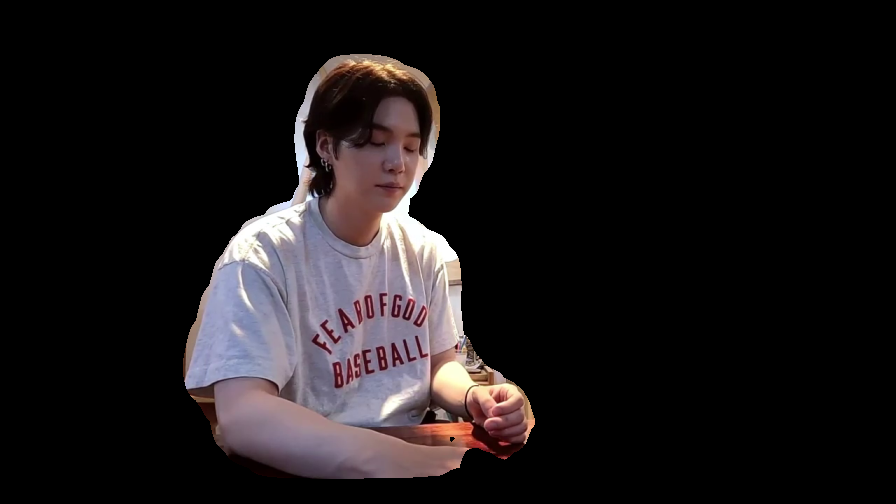

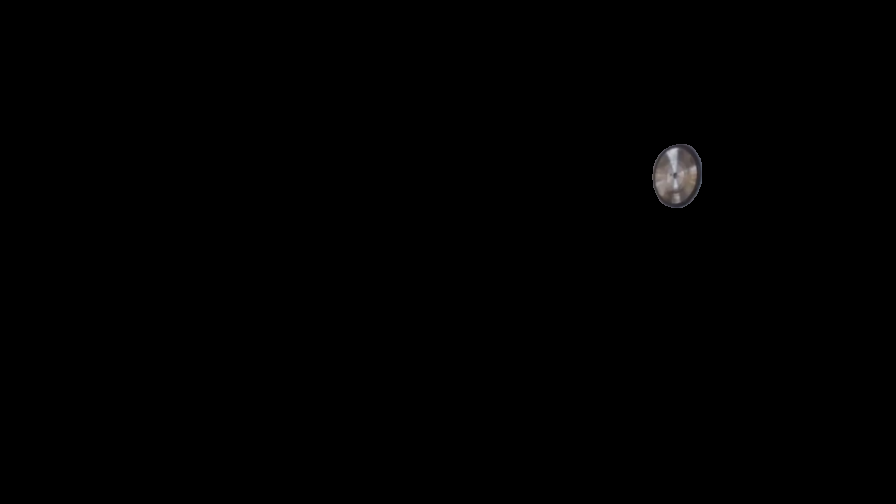

In [14]:
for i in mask_img:
    cv2_imshow(i)
    print()

In [16]:
len(mask_img)

2

In [15]:
dst1 = make_thumbnail_fg(mask_img)

In [16]:
dst2 = make_thumbnail_bg(dst1, bg_image=True, bg_c="sky", text_f="TRIPLEX", text_c="white", text="QWE's VLOG", font_scale=2, font_thickness=2)

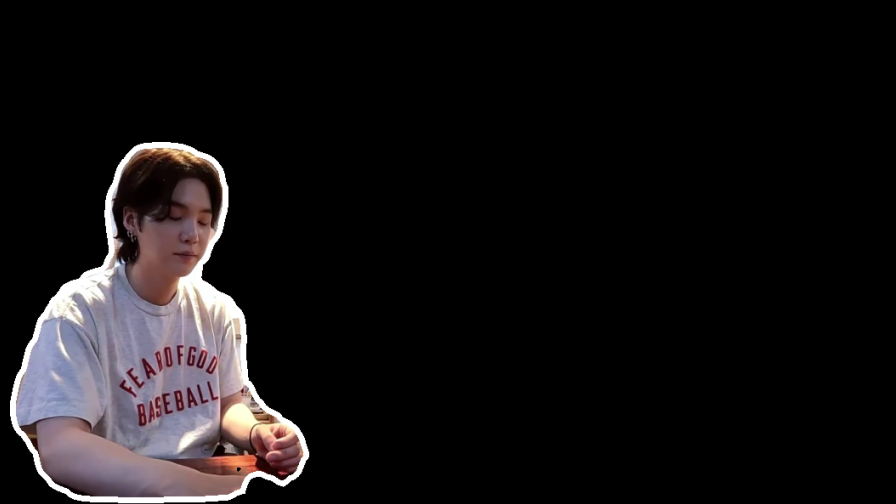

In [17]:
cv2_imshow(dst1)

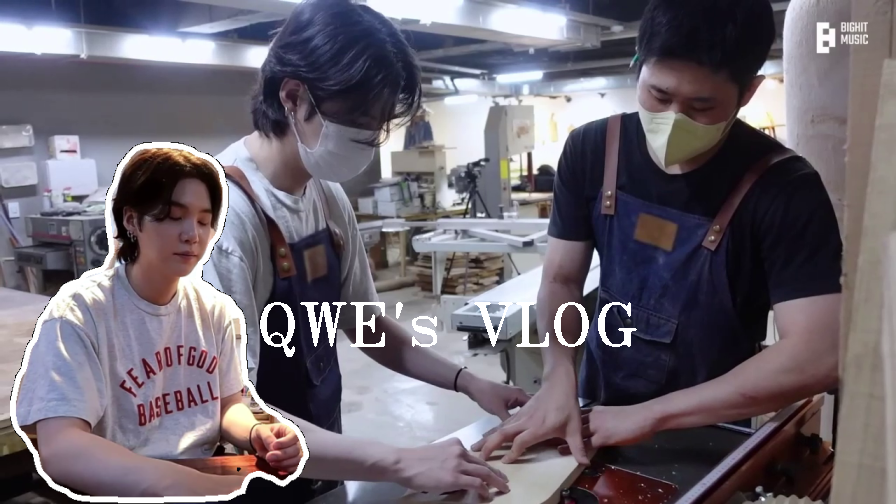

In [18]:
cv2_imshow(dst2)

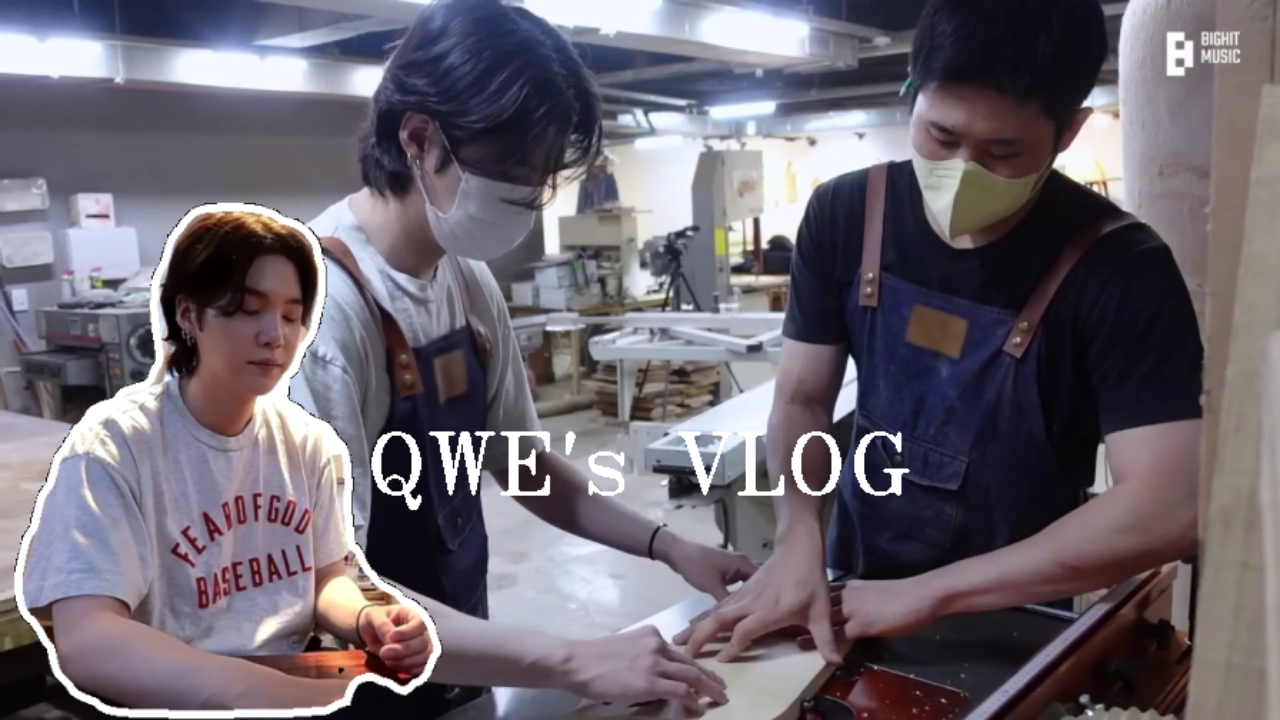

In [19]:
dst = cv2.resize(dst2, (original_width, original_height))
cv2_imshow(dst)

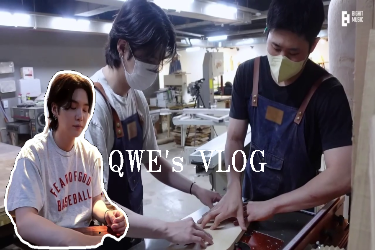

In [20]:
dst = cv2.resize(dst2, (375, 250))
cv2_imshow(dst)

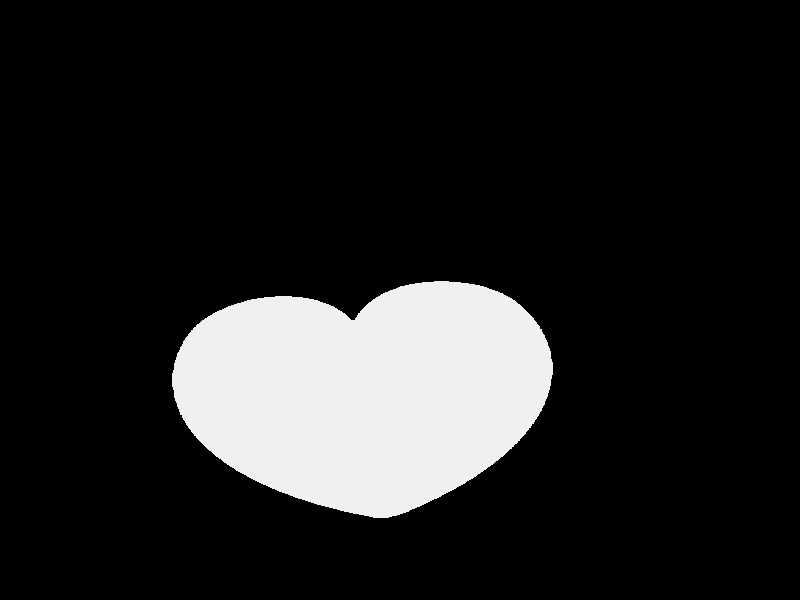

In [29]:
heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart4.jpg", cv2.IMREAD_COLOR)
heart_img = cv2.resize(heart_img, (800, 600))
heart_img_copy = heart_img.copy()

tmp = cv2.cvtColor(heart_img, cv2.COLOR_BGR2GRAY)
_, tmp = cv2.threshold(tmp, 180, 240, cv2.THRESH_BINARY_INV)

# z = cv2.bitwise_and(heart_img, heart_img, mask=tmp)
# cv2_imshow(z)

cv2_imshow(tmp)

In [30]:
# heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/heart_heart_heart.jpg", cv2.IMREAD_COLOR)
heart_img = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/hh.jpg", cv2.IMREAD_COLOR)
heart_img = cv2.cvtColor(heart_img, cv2.COLOR_BGR2HSV)
# heart_img = cv2.resize(heart_img, (800, 600))
heart_img_copy = heart_img.copy()

tmp = cv2.cvtColor(heart_img_copy, cv2.COLOR_HSV2GRAY)

# for i in range(1, cnt):
#     (x, y, w, h, area) = stats[i]



a, b = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(heart_img, a, -1, (255, 255, 255), 11)

# # # # # heart_img = cv2.bitwise_and(heart_img, heart_img, mask=tmp)

cv2_imshow(heart_img)

AttributeError: ignored